# Compute Squared Euclidean Distance

This function have the following cost:
* adds: $D \cdot N (N-1)$
* mults: $\frac{1}{2}D \cdot N (N-1)$
* total: $\frac{3}{2}D \cdot N (N-1)$

So:
$$W = \frac{3}{2}D \cdot N (N-1)\quad flops$$

The memory traffic is computed taking into account that there is warm cache (on the previous step the whole input matrix have been accessed so it should be in cache):
$$Q = 4 \cdot N * N$$

And so the operational intensity is (for high dimensional data):
$$I \approxeq \frac{3}{8} * D = \frac{3}{8} * 28 \times 28 = 294 ~ \text{flops/byte}$$
The computation will be **compute bound**.

For lower dimensional data ($D=2$):
$$I \approxeq \frac{3}{8} * D = \frac{3}{8} * 2 = \frac{6}{8} ~ \text{flops/byte}$$
The computation could be **memory bound**.


# Compute Low Dimensional Affinities

Including all from above plus the computation of t-Student distribution plus the sum of the all normalization factor.
* adds: $N^2 + N^2$
* divs: $N^2$
* total: $3 N^2$

Same memory traffic and the operational intensity will be (with $D=2$):
$$W = \frac{3}{2}D \cdot N (N-1) + 3 N^2\quad flops \approx 6 N^2 \quad flops$$

Hence, the operational intesity will be:
$$I \approxeq \frac{6 N^2}{4 N^2} = \frac{6}{4}$$

The computation will be compute bound.

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from visualization import plot

mpl.rcParams['figure.figsize'] = (8.1, 5)
mpl.rcParams['figure.dpi'] = 600
mpl.rcParams['font.family'] = 'Roboto'
mpl.rcParams['font.size'] = 15

In [3]:
# Define fixed variables of the problem
D = 2

Lets define the flops depending on the input size.

In [4]:
def get_flops(N):
    W = 3/2 * D * N * (N - 1) + 3 * N**2
    return W

Cache sizes and limits taking into account that the working set is:
$$W_{set} = N \cdot D + 2 N^2$$

In [5]:
cache_1 = 32 * 2**10    # 32 KB
cache_2 = 256 * 2**10   # 256 KB
cache_3 = 8 * 2**20.    # 8 MB


N_cache1 = np.sqrt(cache_1 / 4 / 2)
N_cache2 = np.sqrt(cache_2 / 4 / 2)
N_cache3 = np.sqrt(cache_3 / 4 / 2)
print(f"Cache 1 limit size: {N_cache1}")
print(f"Cache 2 limit size: {N_cache2}")
print(f"Cache 3 limit size: {N_cache3}")

Cache 1 limit size: 64.0
Cache 2 limit size: 181.01933598375618
Cache 3 limit size: 1024.0


## System Information

CPU: Intel Core i7-6820HQ @ 2.70GHz

Cache:
* L1 Cache: 32 KB
* L2 Cache: 256 KB
* L3 Cache: 8 MB

Compiler:
`g++-4.9 (Homebrew GCC 4.9.4) 4.9.4`

## Benchmark 1

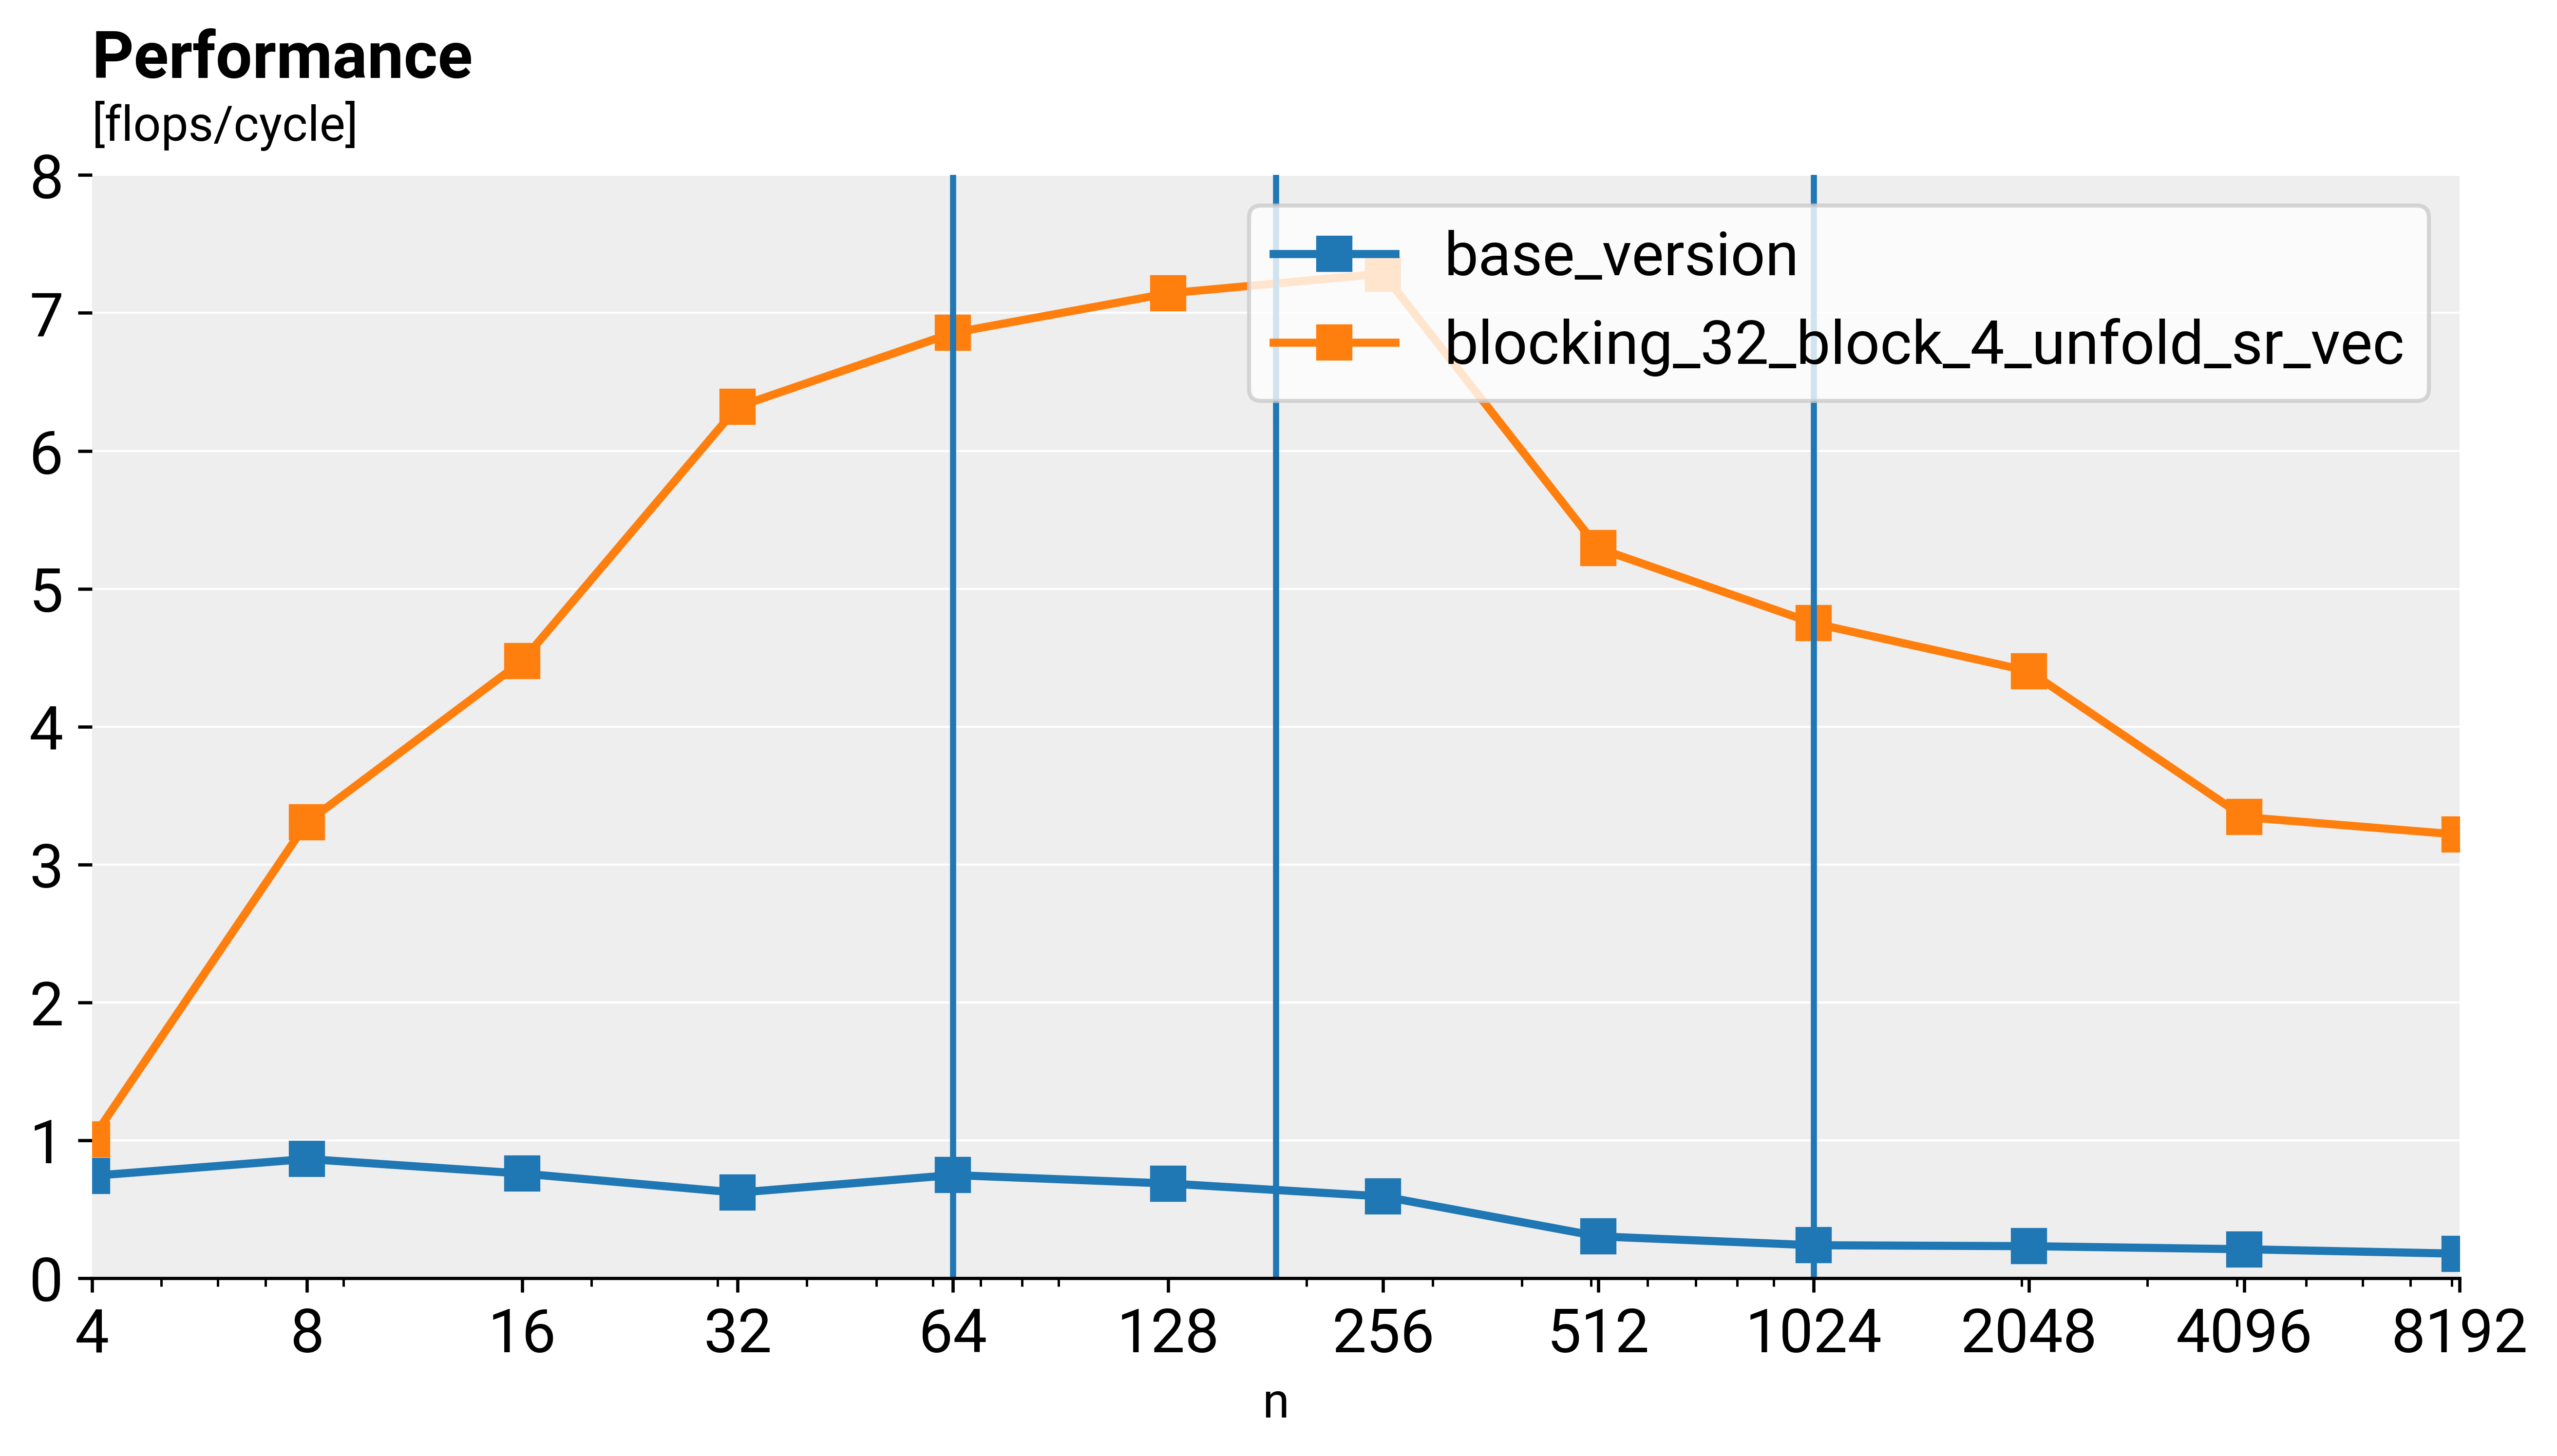

In [6]:
data = pd.read_csv("./bench1.csv")
# Extract the input size
N = data["N"].as_matrix()
# Decompose the data frame into the different functions and compute the performance
func_names = data.columns.values[1:]
perf = []
flops = {
    "base_version": 3/2 * D * N * (N - 1) + 3 * N**2,
    "blocking_32_block_4_unfold_sr_vec": N**2/4**2 * (4*8 + 4*8 + 4*8 + 4*4 + 4*4 + 4*5)
}

for func in func_names:
    cycles = data[func].as_matrix()
    P = flops[func] / cycles
    perf.append(P)
perf = np.array(perf)

ax = plot(N, perf, labels=func_names, ylim=8, title="Performance")
ax.set_xscale("log")
ax.set_xticks(N)
ax.set_xticklabels(N)
ax.axvline(N_cache1)
ax.axvline(N_cache2)
ax.axvline(N_cache3)
plt.show()

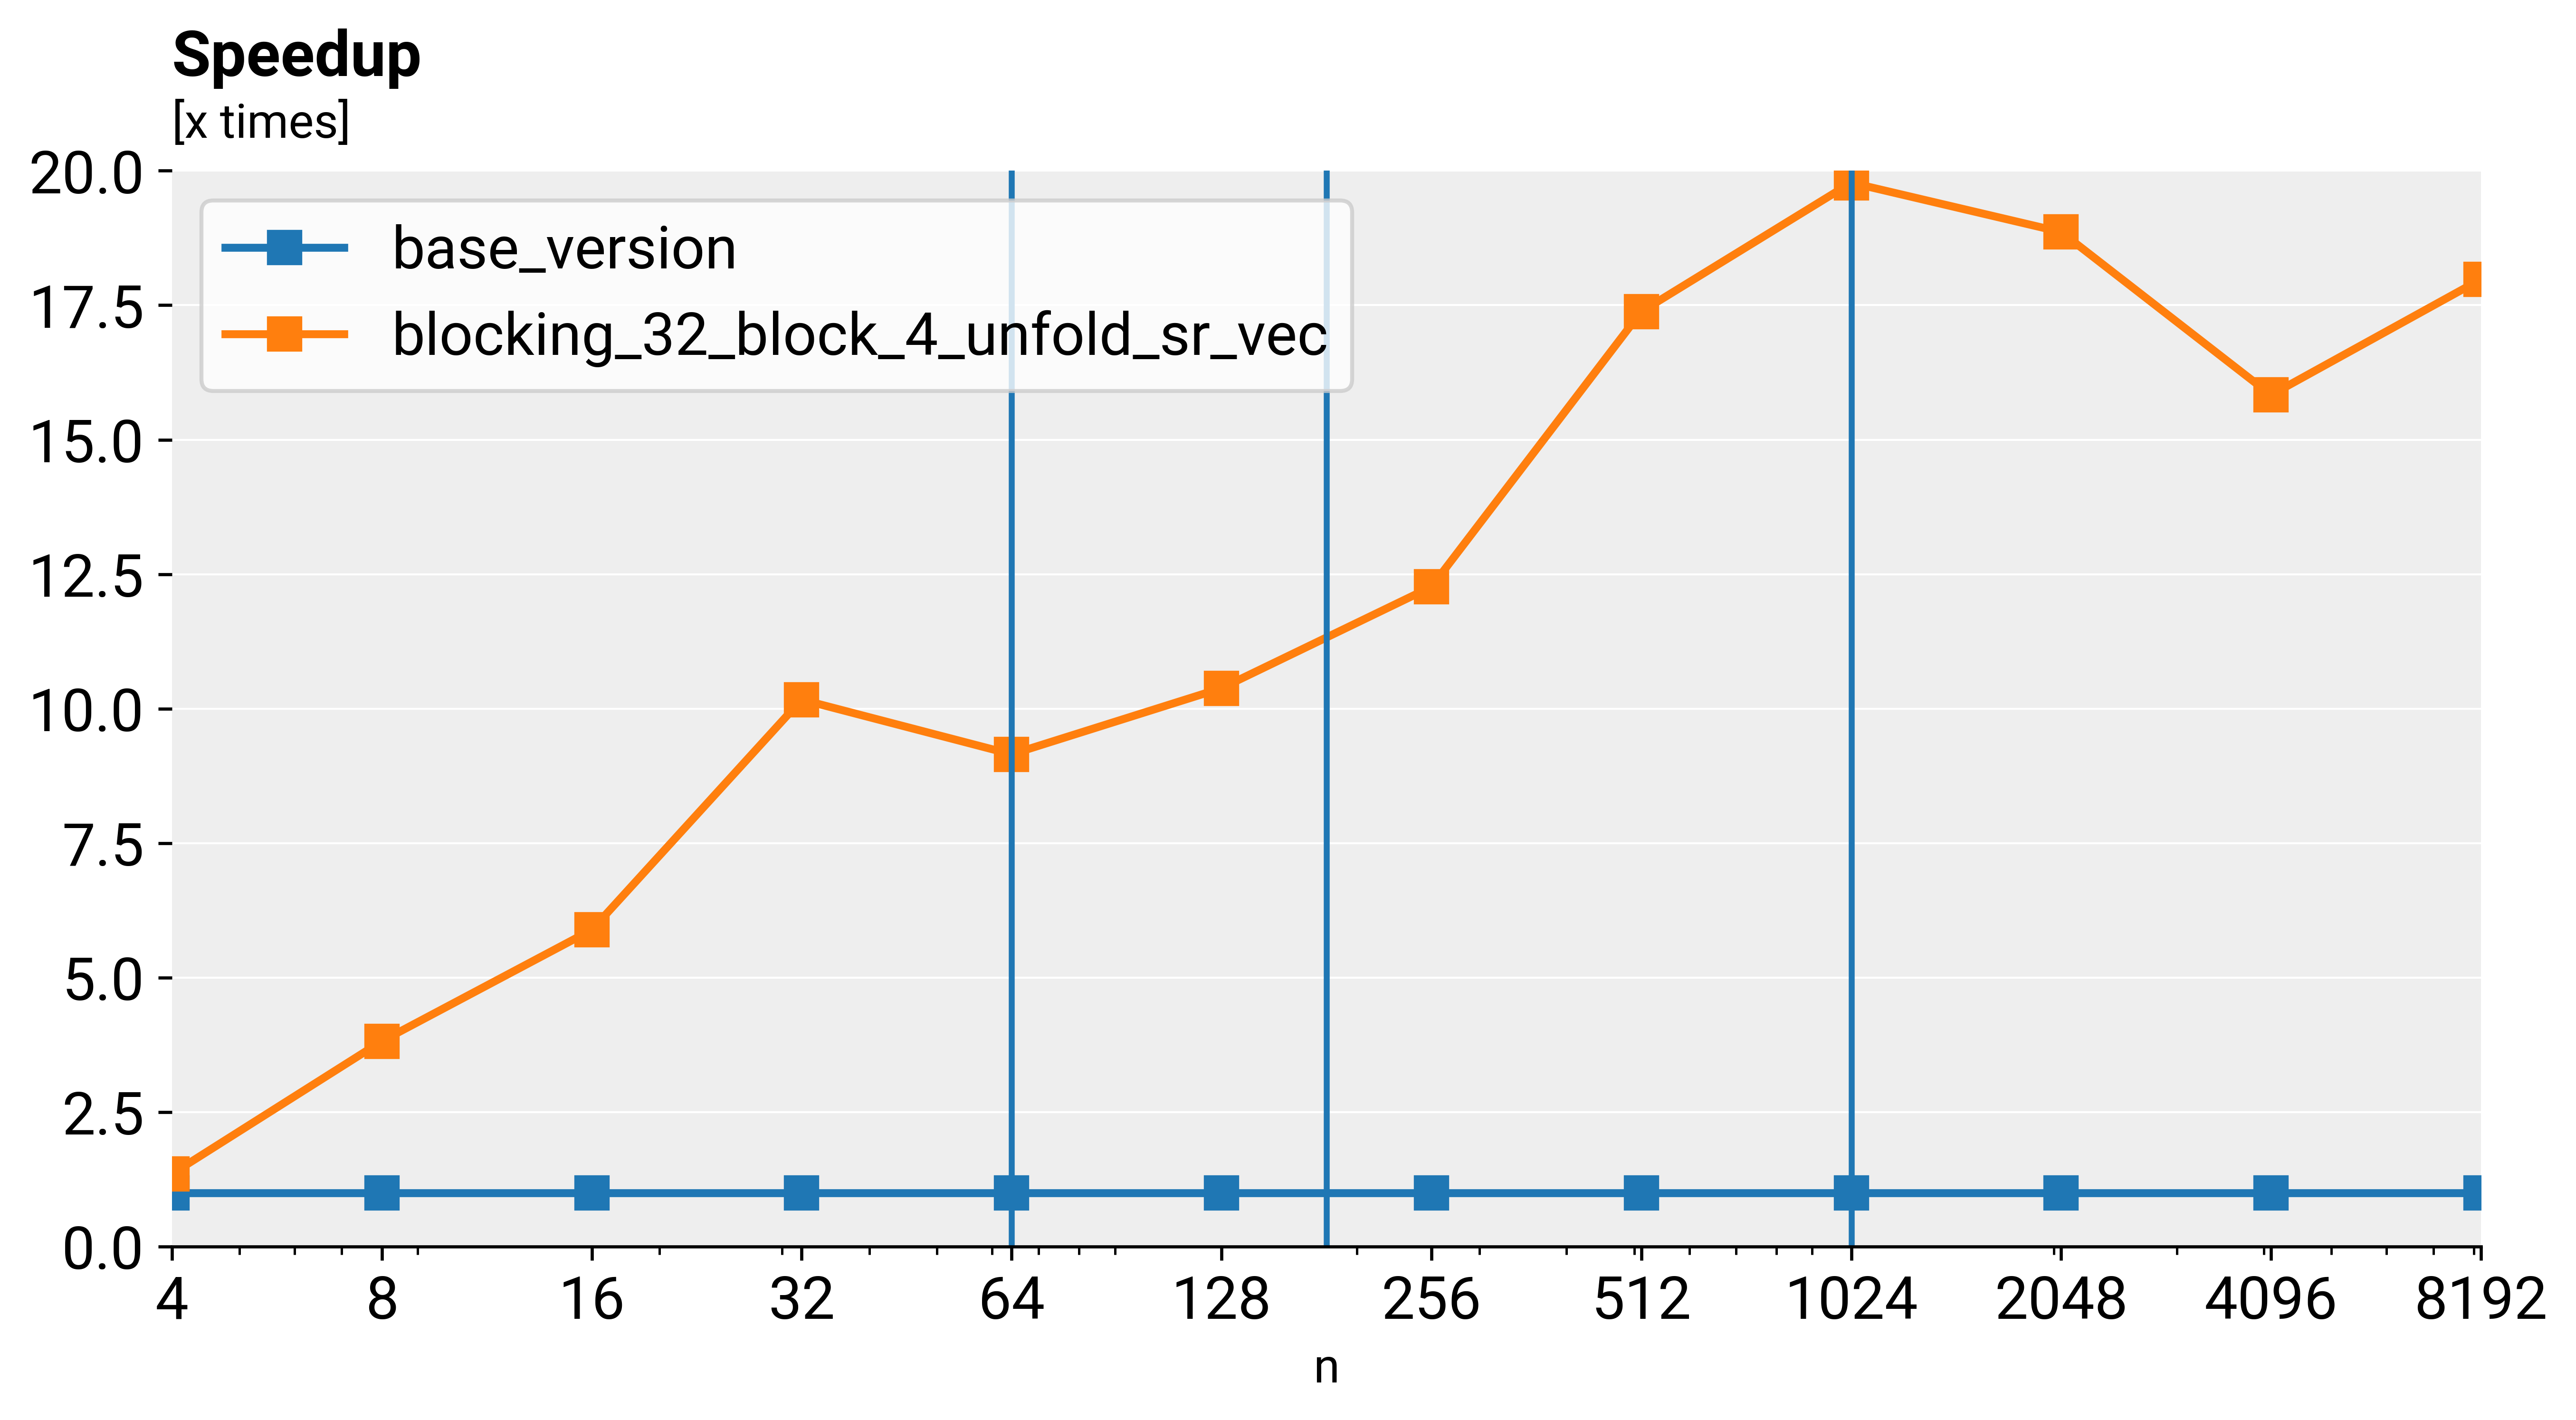

In [8]:
speedup = perf / perf[0,:]
ax = plot(N, speedup, labels=func_names, ylim=20, title="Speedup", ylabel="x times")
ax.set_xscale("log")
ax.set_xticks(N)
ax.set_xticklabels(N)
ax.axvline(N_cache1)
ax.axvline(N_cache2)
ax.axvline(N_cache3)
plt.show()

## Benchmark 2

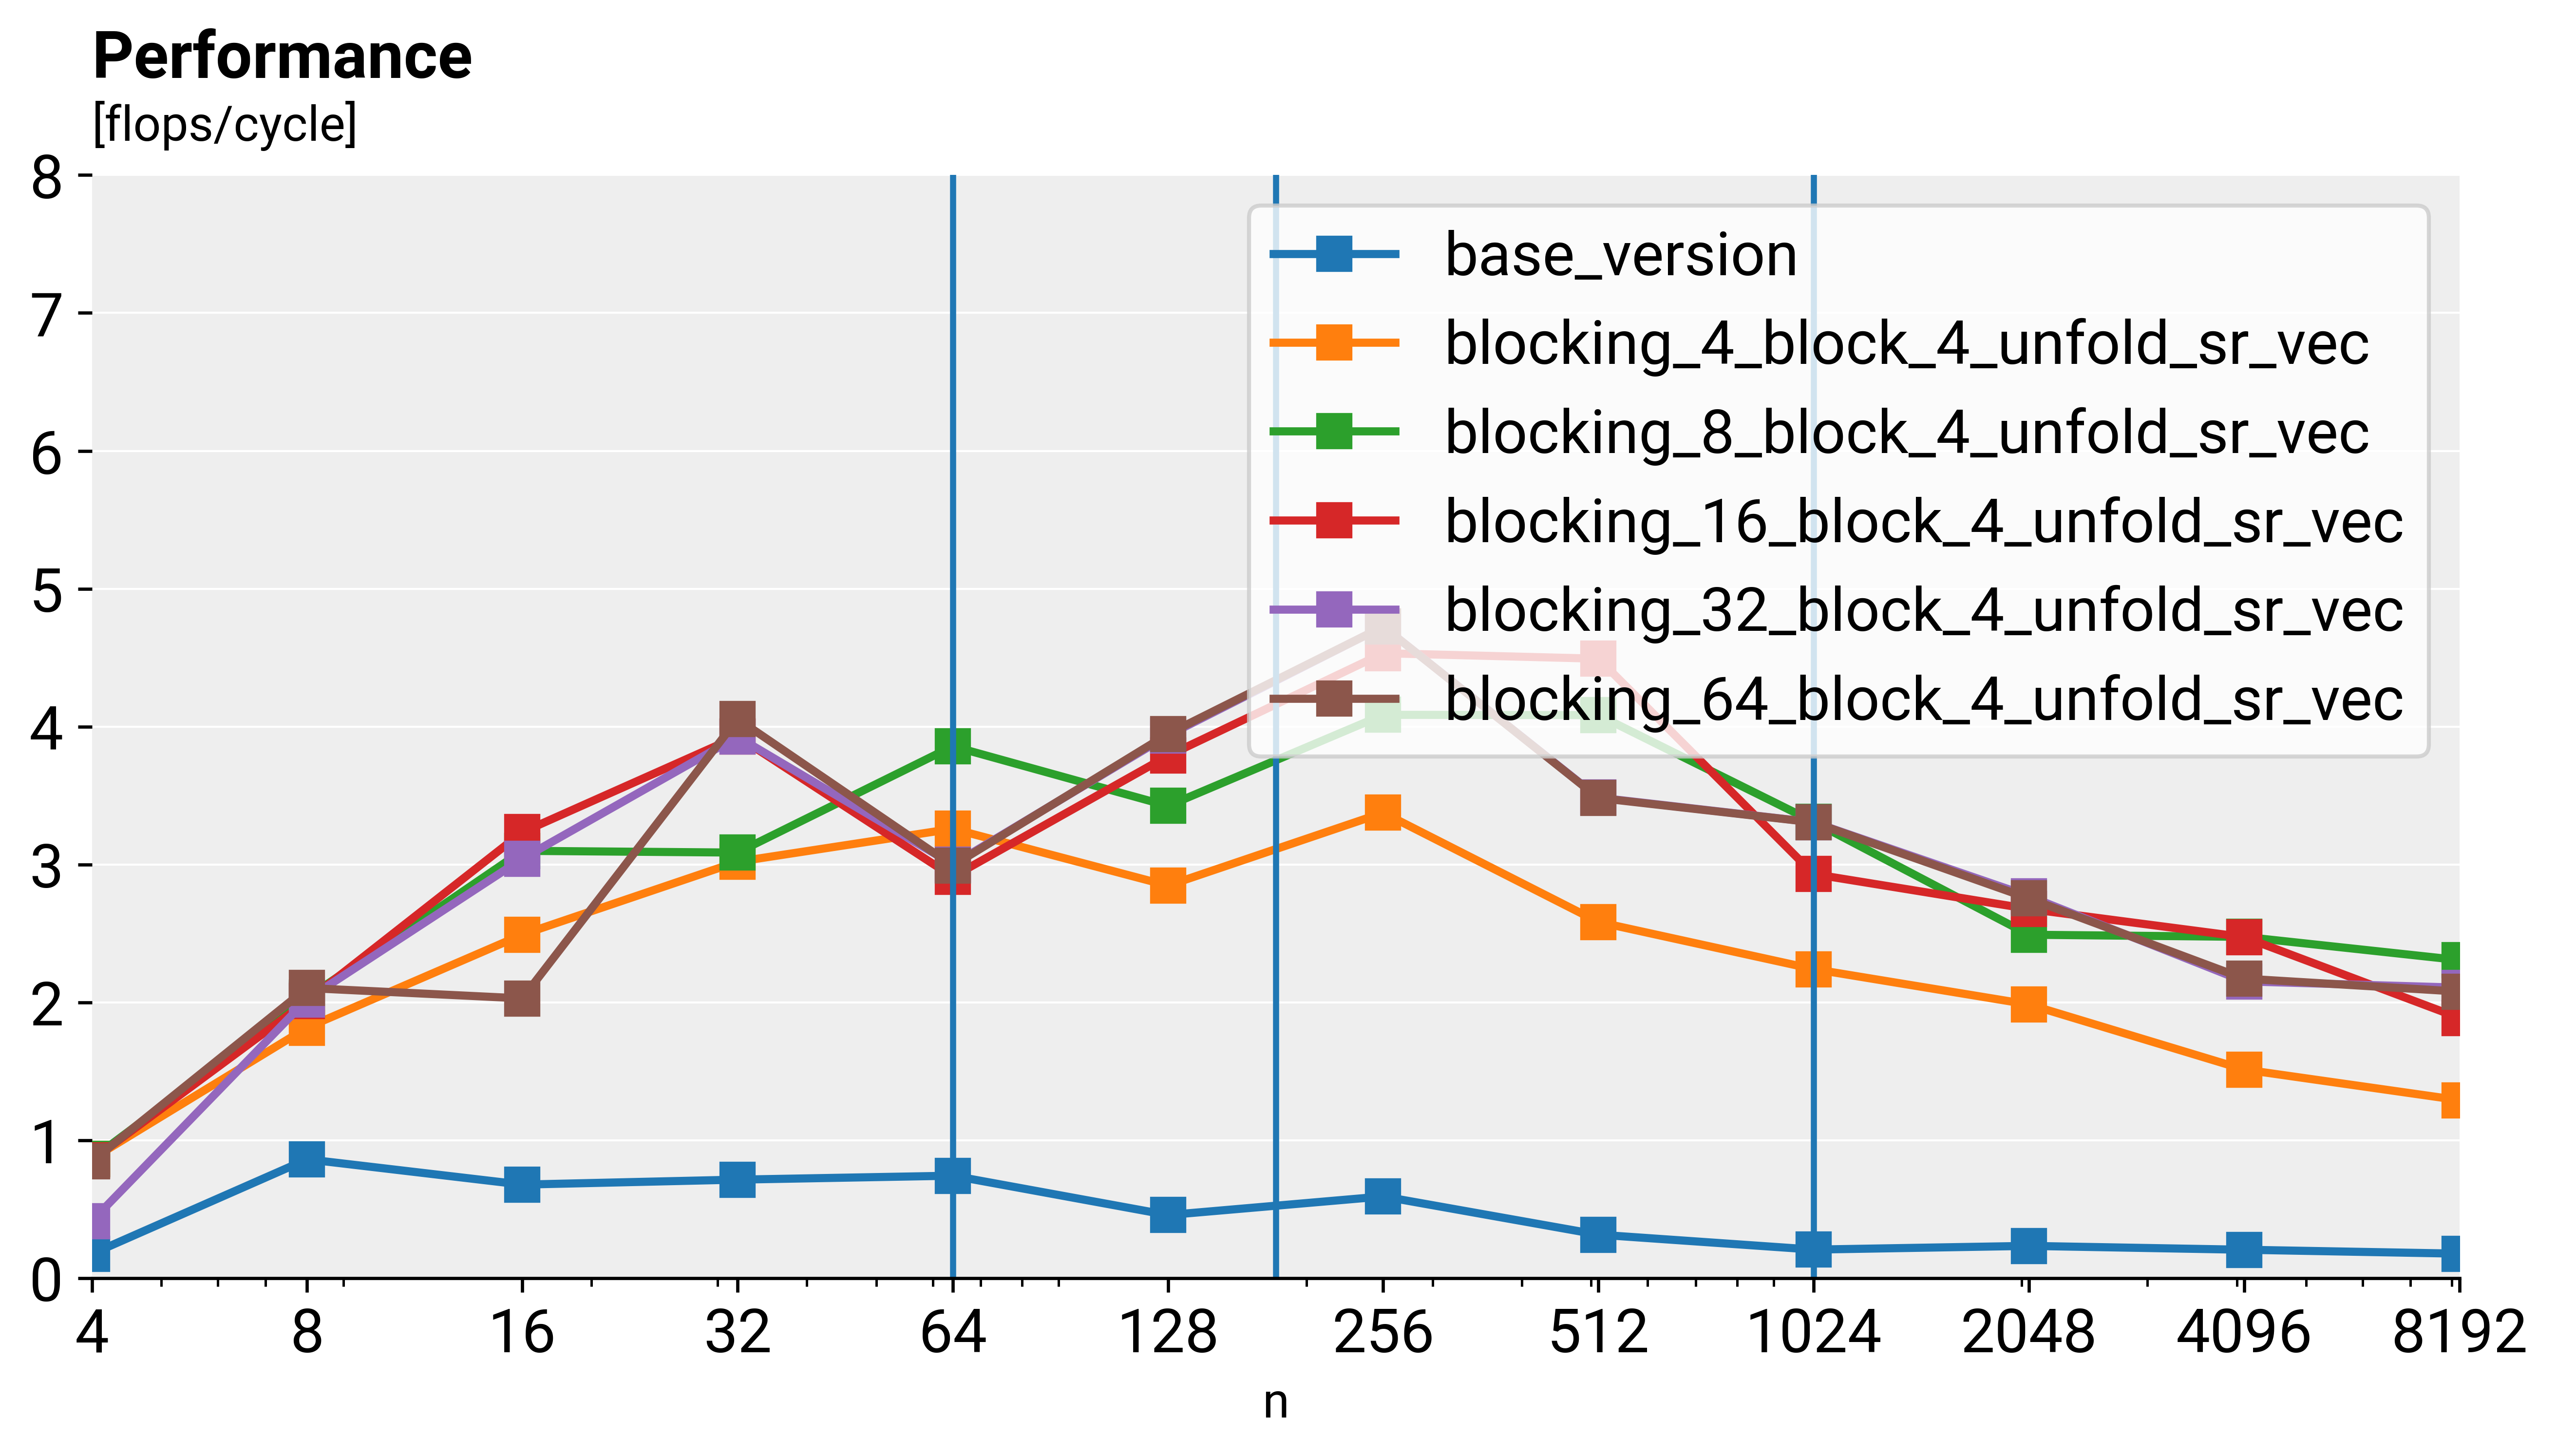

In [22]:
data = pd.read_csv("./bench2.csv")
# Extract the input size
N = data["N"].as_matrix()
# Decompose the data frame into the different functions and compute the performance
func_names = data.columns.values[1:]
perf = []
flops = get_flops(N)

for func in func_names:
    cycles = data[func].as_matrix()
    P = flops / cycles
    perf.append(P)
perf = np.array(perf)

ax = plot(N, perf, labels=func_names, ylim=8, title="Performance")
ax.set_xscale("log")
ax.set_xticks(N)
ax.set_xticklabels(N)
ax.axvline(N_cache1)
ax.axvline(N_cache2)
ax.axvline(N_cache3)
plt.show()

## Benchmark 3

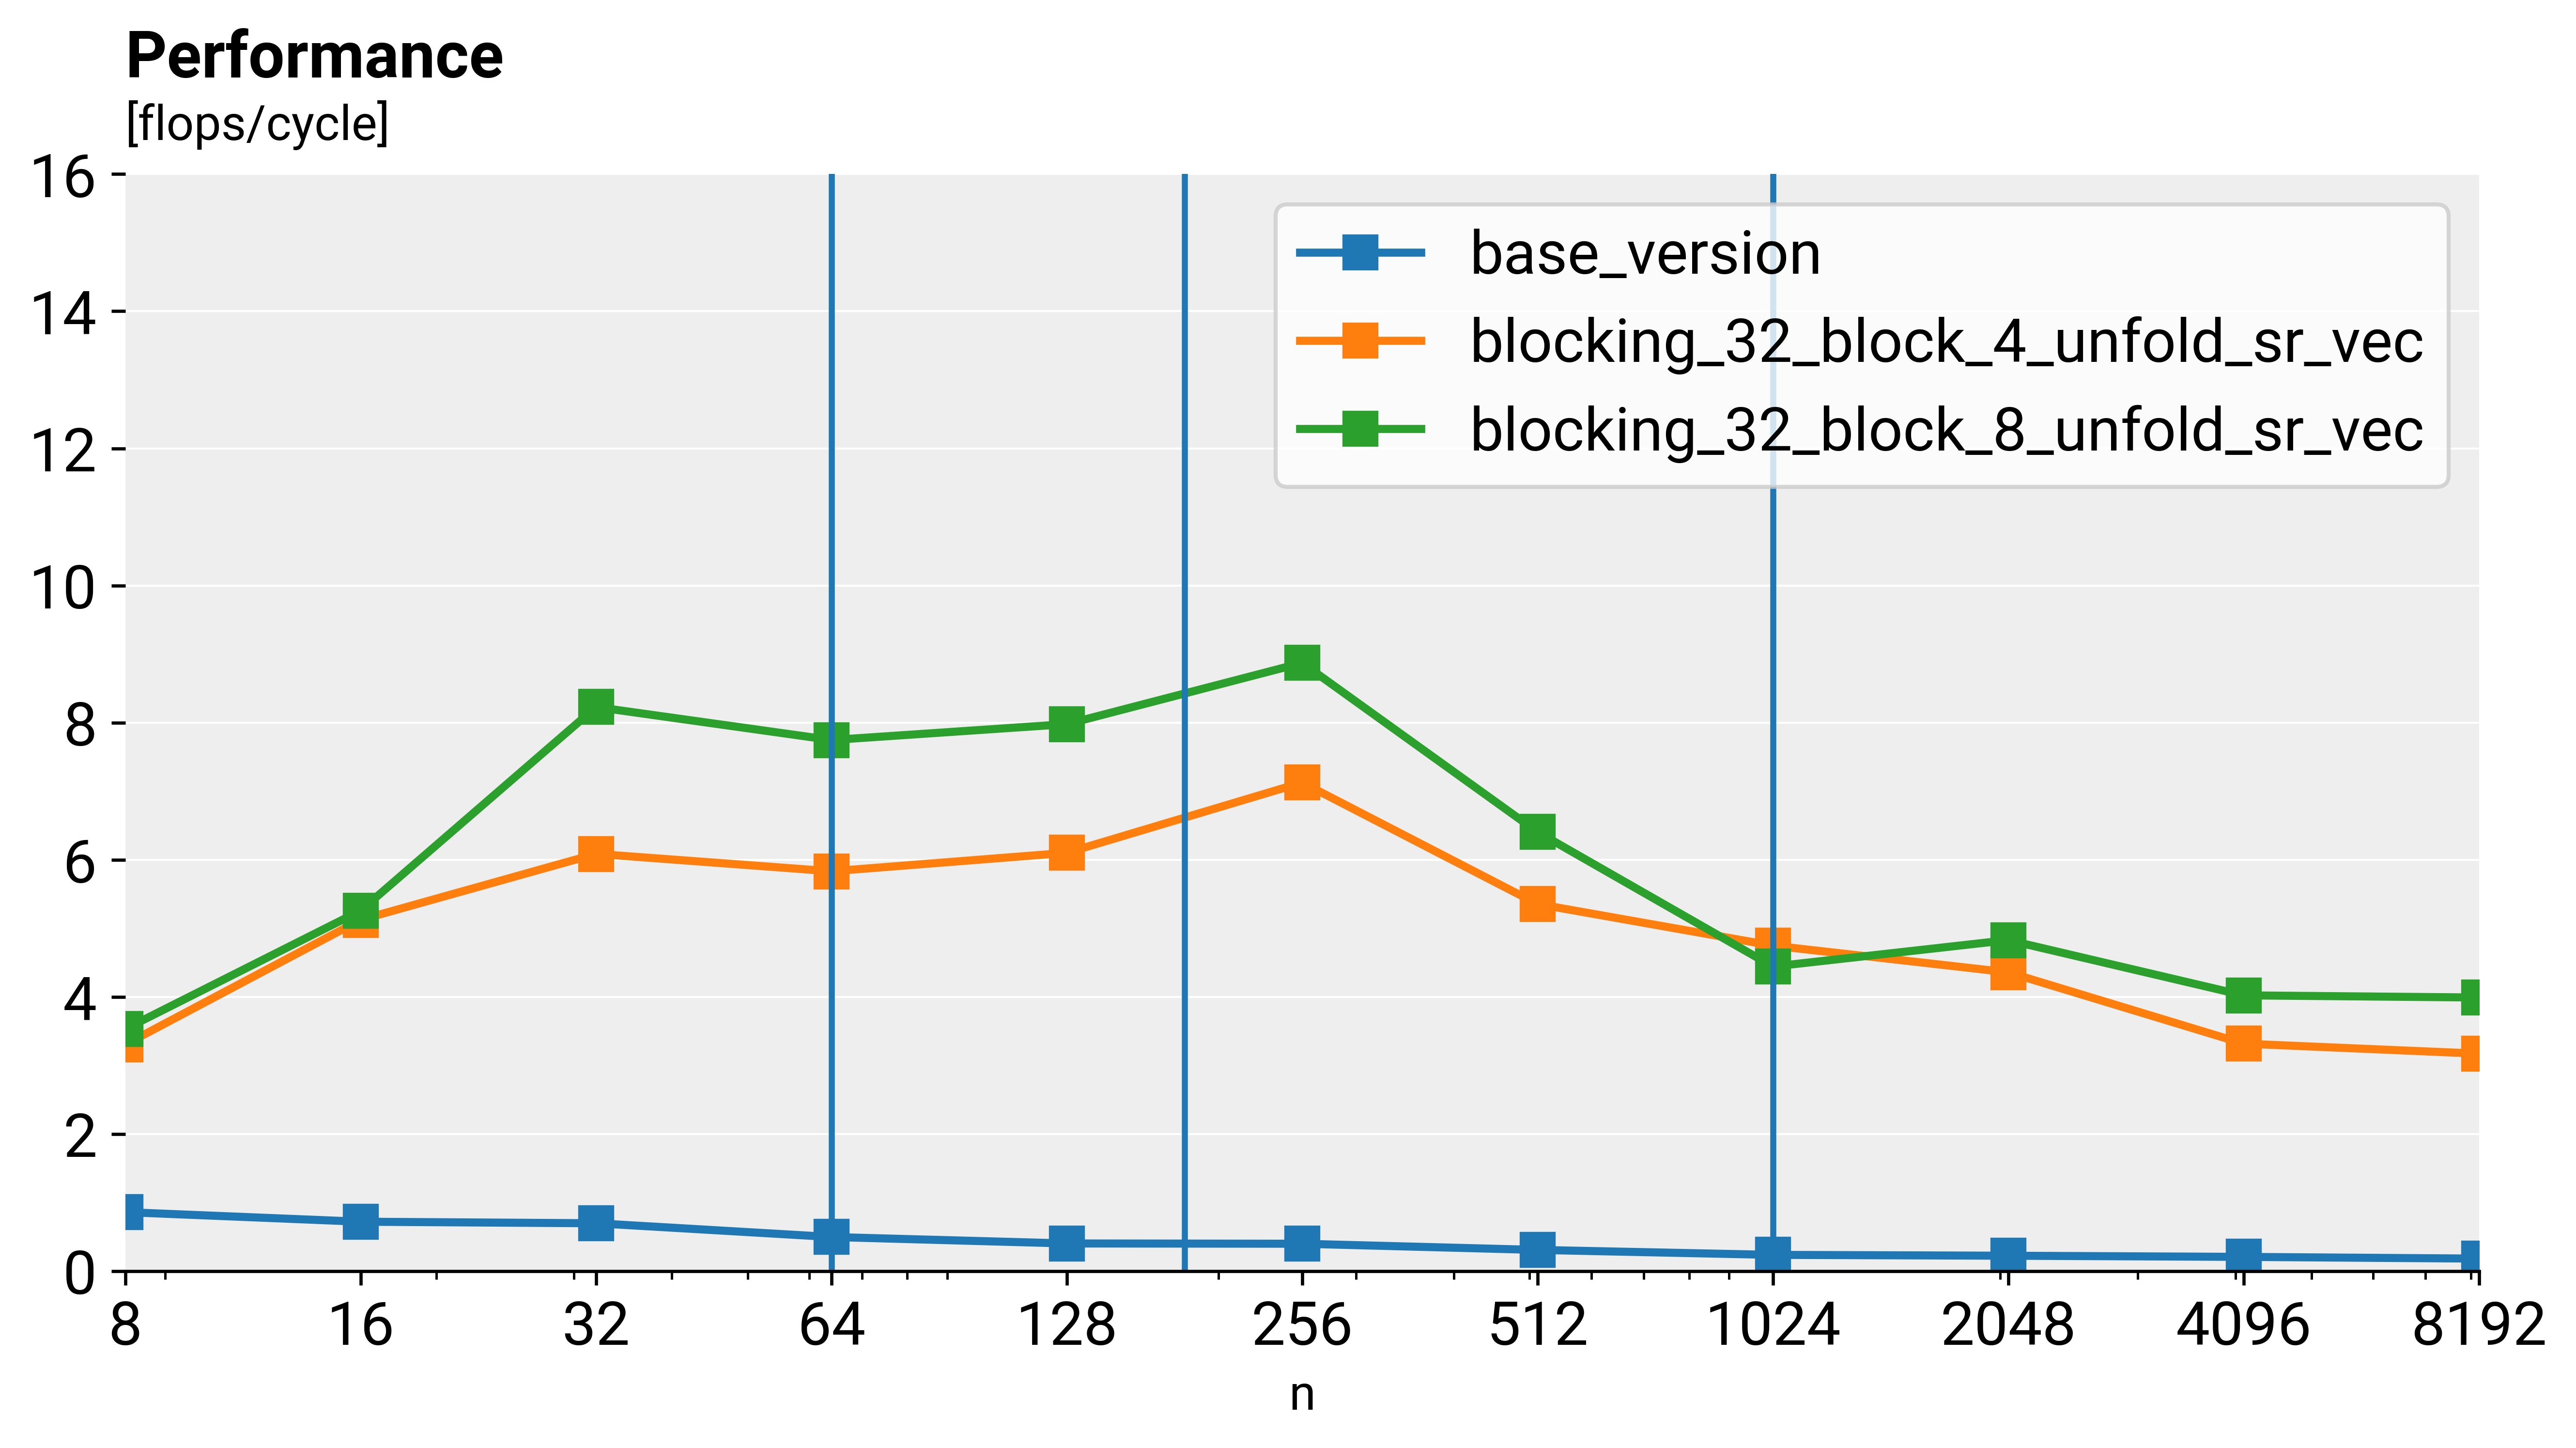

In [14]:
data = pd.read_csv("./bench3.csv")
# Extract the input size
N = data["N"].as_matrix()
# Decompose the data frame into the different functions and compute the performance
func_names = data.columns.values[1:]
perf = []
flops = {
    "base_version": 3/2 * D * N * (N - 1) + 3 * N**2,
    "blocking_32_block_4_unfold_sr_vec": N**2/4**2 * (4*8 + 4*8 + 4*8 + 4*4 + 4*4 + 4*5),
    "blocking_32_block_8_unfold_sr_vec": N**2/8**2 * (16*8 + 16*8 + 16*8 + 8*8 + 8*8 + 8*8)
}

for func in func_names:
    cycles = data[func].as_matrix()
    P = flops[func] / cycles
    perf.append(P)
perf = np.array(perf)

ax = plot(N, perf, labels=func_names, ylim=16, title="Performance")
ax.set_xscale("log")
ax.set_xticks(N)
ax.set_xticklabels(N)
ax.axvline(N_cache1)
ax.axvline(N_cache2)
ax.axvline(N_cache3)
plt.show()

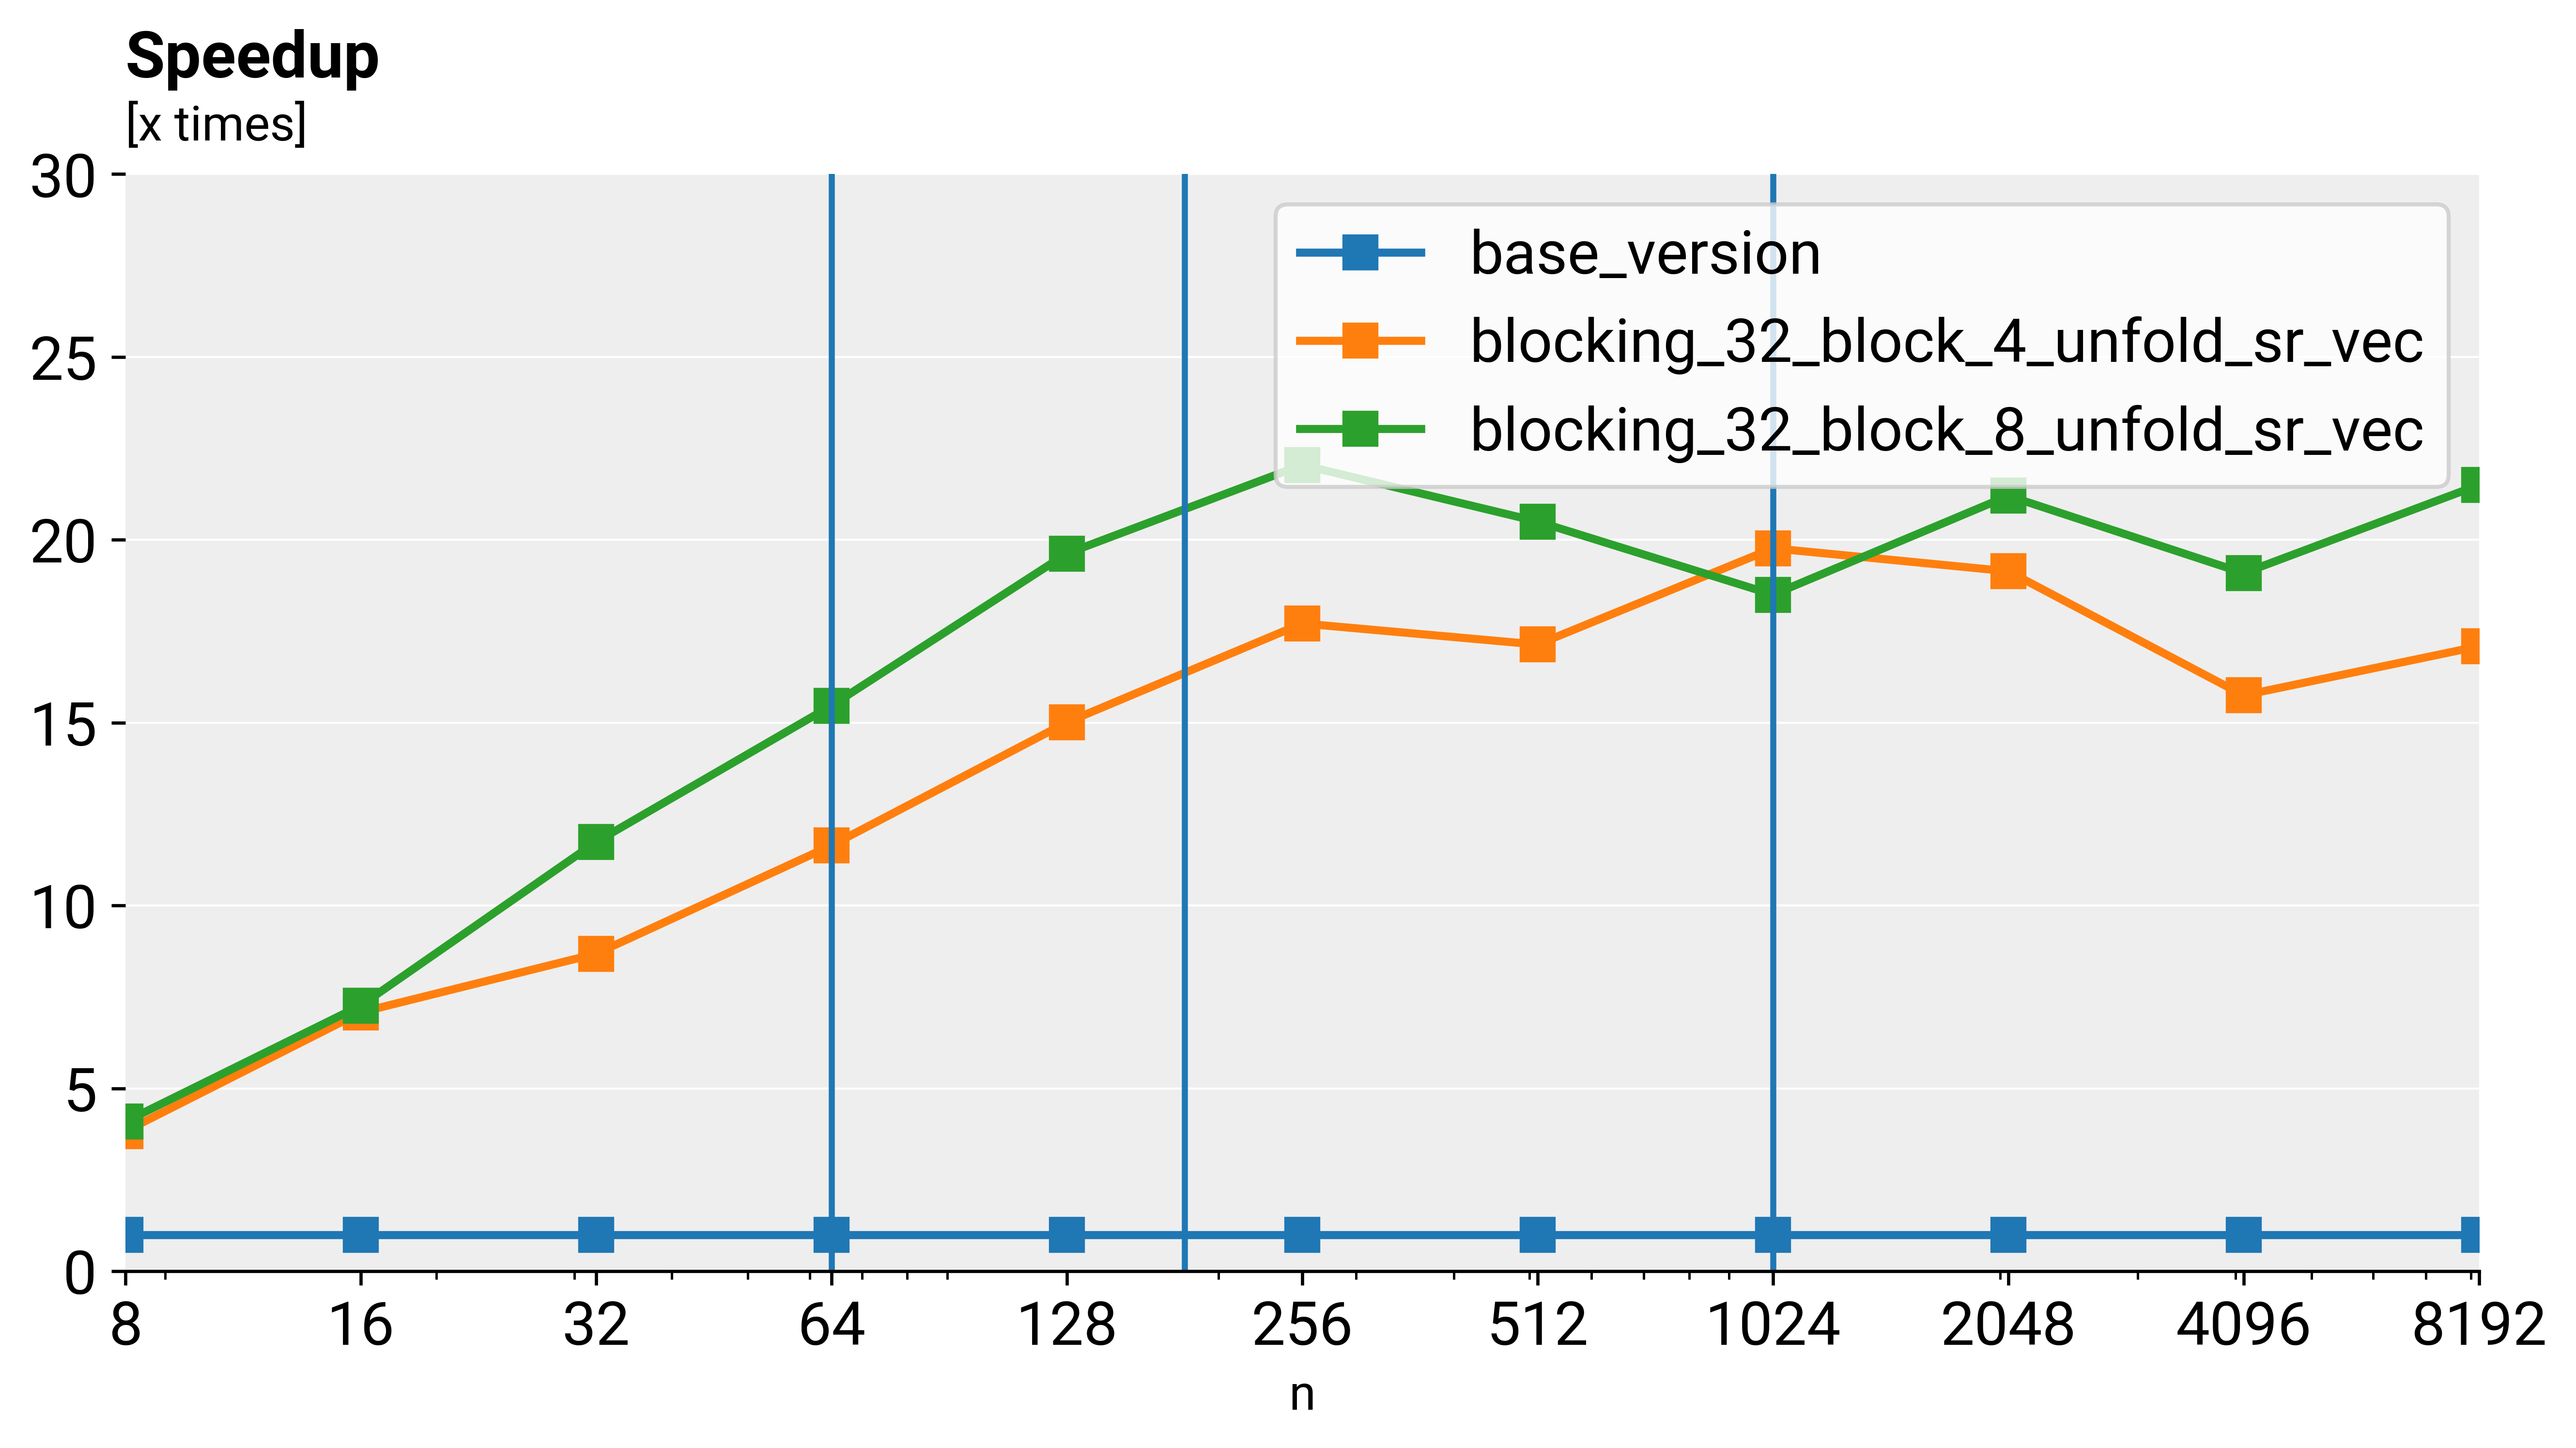

In [16]:
speedup = perf / perf[0,:]
ax = plot(N, speedup, labels=func_names, ylim=30, title="Speedup", ylabel="x times")
ax.set_xscale("log")
ax.set_xticks(N)
ax.set_xticklabels(N)
ax.axvline(N_cache1)
ax.axvline(N_cache2)
ax.axvline(N_cache3)
plt.show()